# Vision Transformers
## Trabajo Práctico 3
### Noelia Qualindi

# Tarea: Fine-tuning de un modelo Vision Transformer

1. **Objetivo**: 
   Seleccione un modelo preentrenado que utilice Vision Transformers (ViTs) y un conjunto de datos adecuado. Realice un proceso de fine-tuning del modelo seleccionado.

   Pueden encontrar la documentacion de Transformers de Hugging Face en [Link](https://huggingface.co/docs/transformers/index)

   Datasets de imágenes en Hugging Face [Link](https://huggingface.co/datasets?modality=modality:image&sort=downloads)

   O pueden usar fuentes de preferencia.

   
2. **Una vez finalizado el fine-tuning**:
   - Justifique la elección del modelo preentrenado y del dataset.
   - Explique el proceso de fine-tuning realizado, especificando los parámetros ajustados y las modificaciones necesarias.
   - Evalúe el rendimiento del modelo preentrenado sin ajustes y compárelo con los resultados obtenidos tras el fine-tuning, discutiendo las mejoras o diferencias observadas.

## Datasets
### Datasets elegidos sobre cancer de mama
El dataset utilizado está compuesto por tres bases de datos combinadas de imágenes relacionadas con el cáncer de mama, etiquetadas como:

0: Benign

1: Malignant

2: Normal

- [Fuente Dataset 1](https://huggingface.co/datasets/gymprathap/Breast-Cancer-Ultrasound-Images-Dataset)
- [Fuente Dataset 2](https://huggingface.co/datasets/realzdlegend/breast_cancer_xray)
- [Fuente Dataset 3 ](https://huggingface.co/datasets/amanvvip2/breast_cancer_images)

In [ ]:
#!pip install datasets

: 

In [87]:
from datasets import load_dataset, concatenate_datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

dataset = load_dataset("gymprathap/Breast-Cancer-Ultrasound-Images-Dataset")
dataset_2 = load_dataset("realzdlegend/breast_cancer_xray")
dataset_3 = load_dataset("amanvvip2/breast_cancer_images")

train_combined = concatenate_datasets([dataset['train'], dataset_2['train'], dataset_3['train']])

train_test_split_dataset = train_combined.train_test_split(test_size=0.3, seed=42)

train_dataset = train_test_split_dataset['train']
test_dataset = train_test_split_dataset['test']

print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Tamaño del conjunto de entrenamiento: 2286
Tamaño del conjunto de prueba: 980


In [88]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1578
    })
})

In [89]:
print(train_dataset)  
print(test_dataset)  

print(type(train_dataset))  
print(type(test_dataset))  

Dataset({
    features: ['image', 'label'],
    num_rows: 2286
})
Dataset({
    features: ['image', 'label'],
    num_rows: 980
})
<class 'datasets.arrow_dataset.Dataset'>
<class 'datasets.arrow_dataset.Dataset'>


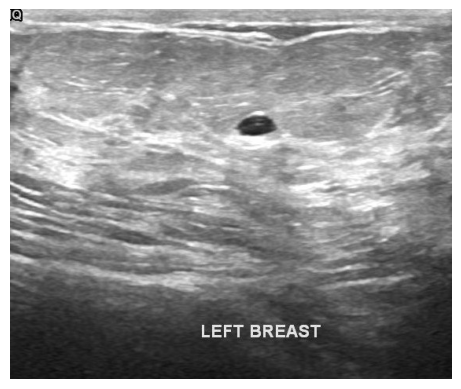

Image 1 info: {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=562x471 at 0x15E27D190>, 'label': 0}


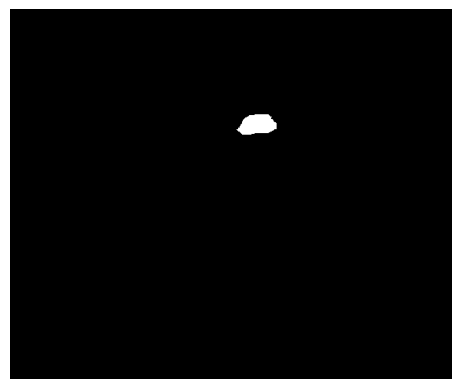

Image 2 info: {'image': <PIL.PngImagePlugin.PngImageFile image mode=1 size=562x471 at 0x5032D8590>, 'label': 0}


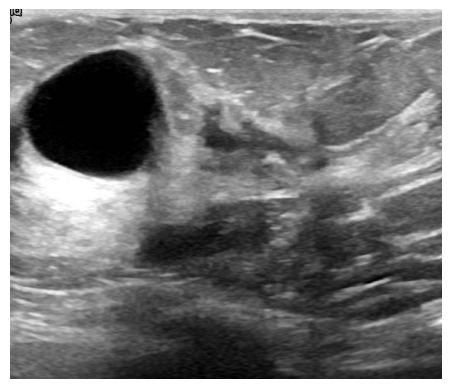

Image 3 info: {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=683x585 at 0x2F1B953D0>, 'label': 0}


In [90]:
from PIL import Image

for i in range(3): 
    image_info = dataset['train'][i]['image']

    if isinstance(image_info, Image.Image):
        image = image_info
    else:
        image = Image.open(image_info['src'])

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    print(f"Image {i + 1} info:", dataset['train'][i])

### Clases del Dataset

In [91]:
id2label = {id:label for id, label in enumerate(train_dataset.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'benign', 1: 'malignant', 2: 'normal'}

### Configuración del modelo preentrenado: CvT

In [92]:
from transformers import AutoFeatureExtractor, CvtForImageClassification, Trainer, TrainingArguments
import torch

feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-13')
model = CvtForImageClassification.from_pretrained('microsoft/cvt-13')


/opt/anaconda3/envs/mipy/lib/python3.11/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [93]:
# Mover el modelo a GPU si está disponible
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)
model.to(device)

mps


CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

##  Preprocesamiento y transformación de las imágenes


In [95]:
print("Antes de aplicar las transformaciones:")
print(len(train_dataset)) 

Antes de aplicar las transformaciones:
2286


In [96]:
from PIL import Image
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

In [97]:
from datasets import load_dataset, concatenate_datasets
from torchvision import transforms
from PIL import Image
import random

# función de transformación para el aumento de datos (en memoria)
def augmented_train(example):
    image = example['image']
    
    if image.mode != 'RGB':
        image = image.convert("RGB")
    
    augmented_image = train_transforms(image)
    
    inputs = feature_extractor(images=augmented_image, return_tensors="pt", padding=True, do_rescale=False)
    example['pixel_values'] = inputs['pixel_values'].squeeze()
    example['label'] = example['label']
    return example

augmented = train_dataset.map(augmented_train)

def transform(example):
    image = example['image']
    
    if image.mode != 'RGB':
        image = image.convert("RGB")
    
    inputs = feature_extractor(images=image, return_tensors="pt", padding=True, do_rescale=False)
    example['pixel_values'] = inputs['pixel_values'].squeeze()
    example['label'] = example['label']
    return example

test_dataset = test_dataset.map(transform)
train_dataset = train_dataset.map(transform)


# Concatenar el conjunto de datos original con el aumentado
train_dataset = concatenate_datasets([train_dataset, augmented])

In [98]:
print(f"Tamaño del conjunto de entrenamiento después del aumento de datos: {len(train_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")

Tamaño del conjunto de entrenamiento después del aumento de datos: 4572
Tamaño del conjunto de prueba: 980


In [99]:
train_dataset.set_format(type='torch', columns=['pixel_values', 'label'])
test_dataset.set_format(type='torch', columns=['pixel_values', 'label'])

## Evaluación del modelo sin fine-tuning

In [100]:
from sklearn.metrics import accuracy_score

def compute_metrics(p):
    predictions, labels = p
    # Asegurarse de que las predicciones son logits, y obtener las clases más probables
    preds = torch.argmax(torch.tensor(predictions), axis=1)  # predecir las clases
    labels = torch.tensor(labels)  # asegurar que las etiquetas son tensores
    accuracy = accuracy_score(labels.numpy(), preds.numpy())  # convertir a numpy para usar accuracy_score
    return {"accuracy": accuracy}


In [101]:
import os
os.environ["WANDB_DISABLED"] = "true" # no utilizamos weights and biases

In [110]:
from torch.utils.data import DataLoader

def evaluate_model(model, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=32)

    model.eval() 
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch['pixel_values'].squeeze(1).float()
            outputs = model(pixel_values=pixel_values.to(device))  # Forward pass
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct += (predictions.to('cpu') == batch['label']).sum().item()
            total += batch['label'].size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [117]:
training_args = TrainingArguments(
    output_dir='./results', 
    per_device_eval_batch_size=16,
    per_device_train_batch_size=16, 
    num_train_epochs=3,
    evaluation_strategy="epoch", 
    logging_dir='./logs', 
    logging_steps=500, 
)


trainer_no_fine_tuning = Trainer(
    model=model,  # El modelo preentrenado sin fine-tuning
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset, 
    compute_metrics=compute_metrics
)

trainer_no_fine_tuning.train()

/opt/anaconda3/envs/mipy/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
 33%|███▎      | 286/858 [02:29<04:40,  2.04it/s]





























































                                         
                                                 
 33%|███▎      | 286/858 [02:39<04:40,  2.04it/s]


{'eval_loss': 0.42015743255615234, 'eval_accuracy': 0.8, 'eval_runtime': 10.3893, 'eval_samples_per_second': 94.328, 'eval_steps_per_second': 5.968, 'epoch': 1.0}


 58%|█████▊    | 500/858 [04:29<03:02,  1.97it/s]

{'loss': 0.7167, 'grad_norm': 19.98225212097168, 'learning_rate': 2.0862470862470865e-05, 'epoch': 1.75}


 67%|██████▋   | 572/858 [05:06<02:15,  2.12it/s]





























































                                         
                                                 
 67%|██████▋   | 572/858 [05:16<02:15,  2.12it/s]


{'eval_loss': 0.412934273481369, 'eval_accuracy': 0.8193877551020409, 'eval_runtime': 10.1596, 'eval_samples_per_second': 96.461, 'eval_steps_per_second': 6.103, 'epoch': 2.0}


100%|██████████| 858/858 [07:44<00:00,  2.03it/s]





























































                                         
                                                 
100%|██████████| 858/858 [07:55<00:00,  2.03it/s]

100%|██████████| 858/858 [07:55<00:00,  1.80it/s]

{'eval_loss': 0.40153178572654724, 'eval_accuracy': 0.8408163265306122, 'eval_runtime': 10.7362, 'eval_samples_per_second': 91.28, 'eval_steps_per_second': 5.775, 'epoch': 3.0}
{'train_runtime': 475.4549, 'train_samples_per_second': 28.848, 'train_steps_per_second': 1.805, 'train_loss': 0.6939586648296365, 'epoch': 3.0}


### Evaluación y métricas del modelo sin fine-tuning

In [126]:
eval_results = trainer_no_fine_tuning.evaluate()

print("Resultados de evaluación del modelo preentrenado sin fine-tuning:")
print(eval_results)
evaluate_model(model, test_dataset)

100%|██████████| 62/62 [00:08<00:00,  7.13it/s]


Resultados de evaluación del modelo preentrenado sin fine-tuning:
{'eval_loss': 0.40153178572654724, 'eval_accuracy': 0.8408163265306122, 'eval_runtime': 9.0561, 'eval_samples_per_second': 108.214, 'eval_steps_per_second': 6.846, 'epoch': 3.0}
Test Accuracy: 81.22%


In [123]:
outputs = trainer_no_fine_tuning.predict(test_dataset)

100%|██████████| 62/62 [00:08<00:00,  7.02it/s]


In [124]:
outputs.metrics

{'test_loss': 0.40153178572654724,
 'test_accuracy': 0.8408163265306122,
 'test_runtime': 9.2052,
 'test_samples_per_second': 106.461,
 'test_steps_per_second': 6.735}

## Entrenamiento del modelo con fine-tuning

In [22]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",  # Directorio para guardar los resultados
    evaluation_strategy="epoch",  # Evaluar al final de cada época
    save_strategy="epoch",  # Guardar el modelo al final de cada época
    logging_strategy="epoch",
    learning_rate=2e-5,  # Tasa de aprendizaje
    per_device_train_batch_size=16,  # Tamaño del batch para entrenamiento
    per_device_eval_batch_size=16,  # Tamaño del batch para evaluación
    num_train_epochs=5,  # Número de épocas
    weight_decay=0.01,  # Regularización L2
    logging_dir="./logs",  # Directorio para los logs
    logging_steps=10,  # Intervalo de pasos para registrar logs
    load_best_model_at_end=True,  # Cargar el mejor modelo al final
    metric_for_best_model="accuracy",  # Métrica para evaluar el mejor modelo
)

trainer = Trainer(
    model=model,  # Modelo a entrenar
    args=training_args,  # Parámetros de entrenamiento
    train_dataset=train_dataset,  # Conjunto de entrenamiento
    eval_dataset=test_dataset,  # Conjunto de validación
    tokenizer=feature_extractor,  # Tokenizer o extractor de características
    compute_metrics=compute_metrics,  # Función de evaluación
)

train_results = trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/var/folders/ml/g_sxsst10mj890krz6gpp0980000gn/T/ipykernel_11897/313297316.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
  3%|▎         | 80/2860 [04:53<2:49:52,  3.67s/it]
                                                 
  1%|▏         | 41/2860 [03:44<23:52,  1.97it/s] 

{'loss': 0.8386, 'grad_norm': 124870.21875, 'learning_rate': 1.6000000000000003e-05, 'epoch': 1.0}
































































                                                 
                                               
  1%|▏         | 41/2860 [03:56<23:52,  1.97it/s]


{'eval_loss': 0.4650863707065582, 'eval_accuracy': 0.8081632653061225, 'eval_runtime': 11.3429, 'eval_samples_per_second': 86.397, 'eval_steps_per_second': 5.466, 'epoch': 1.0}


                                                 
  1%|▏         | 41/2860 [06:23<23:52,  1.97it/s] 

{'loss': 0.7428, 'grad_norm': 106409.3125, 'learning_rate': 1.2e-05, 'epoch': 2.0}































































                                                 
                                               

  1%|▏         | 41/2860 [06:33<23:52,  1.97it/s]



{'eval_loss': 0.44082802534103394, 'eval_accuracy': 0.8377551020408164, 'eval_runtime': 9.5969, 'eval_samples_per_second': 102.116, 'eval_steps_per_second': 6.46, 'epoch': 2.0}


                                                 
  1%|▏         | 41/2860 [09:01<23:52,  1.97it/s] 

{'loss': 0.7094, 'grad_norm': 88026.9609375, 'learning_rate': 8.000000000000001e-06, 'epoch': 3.0}






























































                                                 
                                               

  1%|▏         | 41/2860 [09:11<23:52,  1.97it/s]



{'eval_loss': 0.39483070373535156, 'eval_accuracy': 0.8520408163265306, 'eval_runtime': 9.6399, 'eval_samples_per_second': 101.661, 'eval_steps_per_second': 6.432, 'epoch': 3.0}


                                                 
  1%|▏         | 41/2860 [11:39<23:52,  1.97it/s]  

{'loss': 0.7439, 'grad_norm': 131852.875, 'learning_rate': 4.000000000000001e-06, 'epoch': 4.0}






























































                                                 
                                                

  1%|▏         | 41/2860 [11:48<23:52,  1.97it/s]



{'eval_loss': 0.38111984729766846, 'eval_accuracy': 0.8418367346938775, 'eval_runtime': 9.3317, 'eval_samples_per_second': 105.018, 'eval_steps_per_second': 6.644, 'epoch': 4.0}


                                                 
  1%|▏         | 41/2860 [14:16<23:52,  1.97it/s]  

{'loss': 0.6708, 'grad_norm': 152696.71875, 'learning_rate': 0.0, 'epoch': 5.0}






























































                                                 
                                                

  1%|▏         | 41/2860 [14:26<23:52,  1.97it/s]



{'eval_loss': 0.37812870740890503, 'eval_accuracy': 0.8387755102040816, 'eval_runtime': 10.0885, 'eval_samples_per_second': 97.141, 'eval_steps_per_second': 6.146, 'epoch': 5.0}


                                                 
100%|██████████| 1430/1430 [13:13<00:00,  1.80it/s]

{'train_runtime': 793.348, 'train_samples_per_second': 28.815, 'train_steps_per_second': 1.802, 'train_loss': 0.7411003913079108, 'epoch': 5.0}


In [48]:
torch.save(model.state_dict(), 'modelo_entrenado_fine_tuning.pth')

In [43]:
torch.mps.empty_cache() # limpiamos cache

### Evaluación del modelo con Fine-Tuning

In [56]:
eval_results = trainer.evaluate()
print(f"Accuracy en la evaluación lograda con el conjunto de validación: {eval_results['eval_accuracy']}")

100%|██████████| 62/62 [00:08<00:00,  7.09it/s]

Accuracy en la evaluación lograda con el conjunto de validación: 0.8520408163265306


In [45]:
print(test_dataset)

Dataset({
    features: ['image', 'label', 'pixel_values'],
    num_rows: 980
})


In [62]:
evaluate_model(model, test_dataset)

Test Accuracy: 85.20%


### Pruebas 

100%|██████████| 62/62 [00:09<00:00,  6.81it/s]


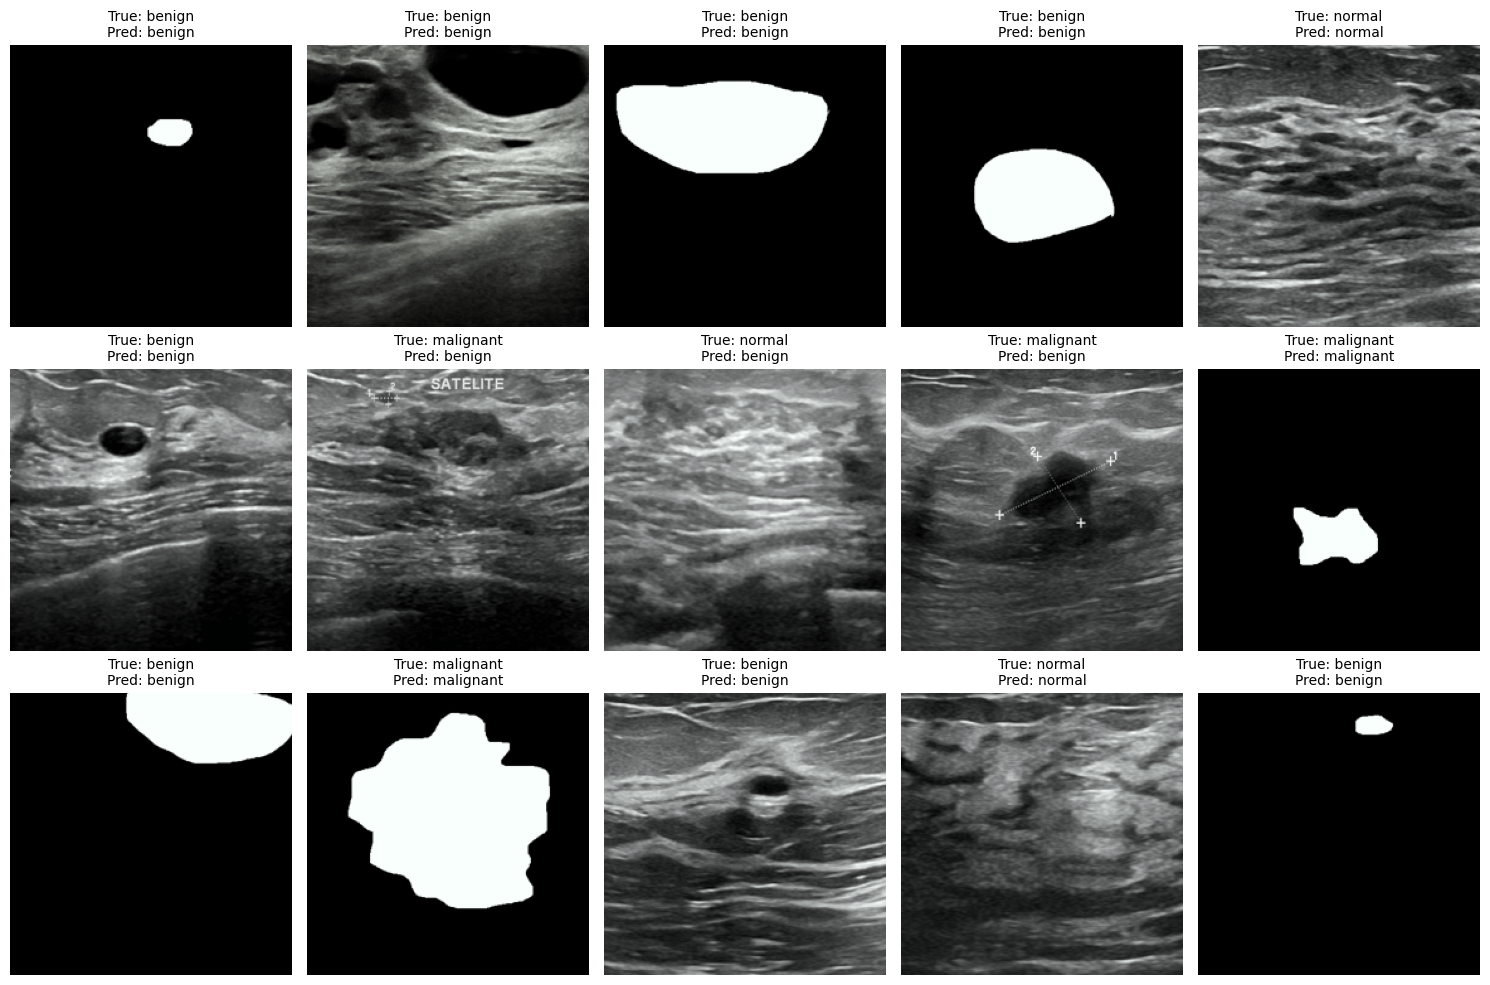

In [64]:
import random
import matplotlib.pyplot as plt
import torch

predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

class_names = {0: 'benign', 1: 'malignant', 2: 'normal'}
random_indices = random.sample(range(len(test_dataset)), 15)

fig, axes = plt.subplots(3, 5, figsize=(15, 10))  # 3 filas, 5 columnas
axes = axes.flatten()

for idx, ax in zip(random_indices, axes):
    sample = test_dataset[idx]
    image = sample['pixel_values']
    true_label = int(sample['label']) 
    
    true_label_name = class_names[true_label]
    pred_label_name = class_names[predicted_labels[idx].item()]
    
    # Ajusta la imagen a formato [H, W, C]
    image = image.permute(1, 2, 0).numpy()  # cambia de [C, H, W] a [H, W, C]
    
    # normalizar la imagen si es necesario
    if image.max() > 1 or image.min() < 0:
        image = (image - image.min()) / (image.max() - image.min())  # normalizar entre 0 y 1
    
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", fontsize=10)

plt.tight_layout()
plt.show()

In [66]:
predictions.metrics

{'test_loss': 0.39483070373535156,
 'test_accuracy': 0.8520408163265306,
 'test_runtime': 9.6442,
 'test_samples_per_second': 101.615,
 'test_steps_per_second': 6.429}

### Matriz de confusión

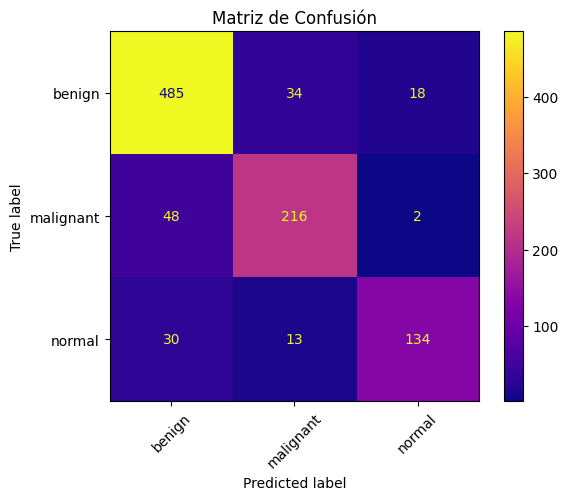

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)

labels = [class_names[i] for i in range(len(class_names))]

# Visualización de la matriz de confusión con nombres de clase
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='plasma', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()

# Conclusiones

## Justificación del Modelo Preentrenado y del Dataset
**Modelo Preentrenado elegido: Convolutional Vision Transformer (CvT)**

El modelo preentrenado elegido, en principio es adecuado para tareas de visión por computadora debido a su capacidad para combinar las ventajas de los transformadores y las convoluciones. La arquitectura de CvT está diseñada para aprovechar los beneficios de los transformers en el procesamiento de imágenes, al mismo tiempo que mantiene una estructura eficiente en términos de computación gracias a las convoluciones.

Ventajas: CvT es un modelo robusto y eficiente que ha mostrado un buen desempeño en diversas tareas de clasificación de imágenes. Su estructura híbrida permite capturar tanto las características locales (a través de convoluciones) como las globales (a través de la atención de los transformadores). 
Esto lo hace adecuado para tareas complejas de clasificación, como la detección de tumores en imágenes médicas.

Razón de la elección: Se eligió el modelo CvT de Hugging Face porque es un modelo de vanguardia que ha sido entrenado en grandes bases de datos de imágenes y ofrece una transferencia de aprendizaje poderosa para tareas de clasificación, especialmente en conjuntos de datos pequeños o específicos como el de imágenes médicas.

### Dataset
Características: El dataset es adecuado para clasificación multiclase, donde el modelo debe distinguir entre tres clases (benigno, maligno y normal). La elección de este dataset es relevante ya que el diagnóstico de cáncer de mama es una tarea crítica en la medicina, y se han creado varios datasets públicos para entrenamiento y evaluación de modelos de clasificación de imágenes médicas.

Razón de la elección: Además de que es eficiente en tareas de visión con reducción de complejidad computacional, el dataset elegido con imágenes médicas permite entrenar el modelo para tareas de clasificación importantes y puede proporcionar un buen contexto para evaluar el rendimiento del modelo CvT. Al combinar varios datasets, se aumenta la diversidad de los datos, lo que puede ayudar a mejorar la generalización del modelo.

Se realizó una augmentación de los datos con el objetivo de aumentar el número de imágenes en el conjunto de entrenamiento y además, alterarlas un poco (como la rotación, flip, etc) para mejorar el rendimiento del modelo(en lo posible). 

## Evaluación del Modelo Preentrenado y Comparación con el Fine-Tuning

#### Resultados del Modelo Preentrenado sin Fine-Tuning

- Test Accuracy: 81.22%
- Test Loss: 0.4015
- Detalles de Evaluación: El modelo preentrenado fue evaluado sin ningún ajuste (fine-tuning), y la precisión obtenida fue del 81.22%. Esto indica que el modelo fue capaz de aprender de las imágenes de cáncer de mama sin necesidad de realizar ajustes adicionales, aunque la precisión no es tan alta como podría ser después de un fine-tuning.

#### Resultados del Modelo con Fine-Tuning

Parámetros ajustados: 
- learning_rate = 2e-5
- epochs = 5
- evaluation_strategy="epoch"
- save_strategy="epoch"
- logging_strategy="epoch"
- weight_decay=0.01
- er_device_train_batch_size=16
- per_device_eval_batch_size=16
- load_best_model_at_end=True
- metric_for_best_model="accuracy"

en Trainer: 
- tokenizer = feature_extractor (asegura de que los datos de entrada estén correctamente preprocesados)

Resultados:
- Test Accuracy: 85.20%
- Test Loss: 0.3948
- Detalles de Evaluación: Después de realizar el fine-tuning, el modelo alcanzó una precisión de 85.20%, lo que representa una mejora con respecto al modelo sin ajustes. El test loss también se redujo ligeramente, lo que indica que el modelo aprendió mejor las características del dataset específico después del fine-tuning.
Comparación de Resultados


#### Mejoras Observadas:
- Precisión: El modelo con fine-tuning logró un aumento de aproximadamente 4 puntos en precisión (del 81.22% al 85.20%).
- Pérdida: La pérdida de test también se redujo ligeramente, lo que indica que el modelo ajustado es más eficiente para predecir las clases correctamente.
- Discusión: 
    - Importancia del Fine-Tuning: permite que el modelo aproveche las características aprendidas previamente en grandes datasets, pero ajustándolas para que se adapten mejor a la tarea específica (en este caso, la clasificación de imágenes de cáncer de mama). Este ajuste permite una mejora significativa en el rendimiento del modelo.
    - Tasa de Aprendizaje: El uso de una tasa de aprendizaje pequeña y la configuración adecuada de las épocas probablemente contribuyeron a evitar el sobreajuste mientras se realizaban los ajustes finos.
    - Impacto en el Rendimiento: Aunque el modelo preentrenado ya tenía un buen rendimiento, el fine-tuning permitió mejorar la precisión, lo que demuestra la importancia de realizar ajustes finos en modelos preentrenados cuando se trabaja con conjuntos de datos específicos.


Se observa que el modelo CvT preentrenado se mostró efectivo incluso sin fine-tuning, alcanzando una precisión razonable del 81.22%. Sin embargo, el fine-tuning con un pequeño número de épocas, utilizando extracción de features y una tasa de aprendizaje cuidadosamente ajustada mejoró significativamente el desempeño, alcanzando una precisión del 85.20%. Esto resalta la importancia de ajustar modelos preentrenados a tareas específicas para lograr el mejor rendimiento posible.